In [1]:
import numpy as np
import copy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, cross_validate, KFold
import os
from sklearn.metrics import confusion_matrix
import random
from itertools import chain
import lightgbm as lgb
from scipy.misc import derivative
from sklearn.metrics import average_precision_score
import joblib
import shap
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV

random.seed(a=2021, version=2)

AUGMENT = False
RUN_NUM = 3 # the number of synthetic datasets for each model
RECALL_THRESHOLD = 0.6  # hold this to compute other threshold related metrics
LABEL_INDEX = 5  # label column index in the dataset

CAT_IDX = [int(ele) for ele in list(np.linspace(0, 2586, num=2587))]  # include race columns, no label
RACE_COL = [0,1,2,3,4]
CAT_IDX_wo_RACE_label = [int(ele) for ele in list(np.linspace(0, len(set(CAT_IDX)-set(RACE_COL))-1, len(set(CAT_IDX)-set(RACE_COL))))]
COL_LIST = ['GENDER_SOURCE_VALUE',  'C008', 'C008.5', 'C008.52', 'C008.6', 'C010', 'C038', 'C038.1', 'C038.3', 'C041', 'C041.1', 'C041.11', 'C041.12', 'C041.2', 'C041.4', 'C041.8', 'C041.9', 'C053', 'C053.1', 'C054', 'C070', 'C070.2', 'C070.3', 'C070.4', 'C070.9', 'C071', 'C071.1', 'C078', 'C079', 'C079.2', 'C079.9', 'C080', 'C081', 'C090', 'C090.2', 'C1000', 'C1001', 'C1004', 'C1005', 'C1006', 'C1008', 'C1009', 'C1010', 'C1010.4', 'C1010.5', 'C1010.6', 'C1010.7', 'C1011', 'C1013', 'C1014', 'C1015', 'C1019', 'C1089', 'C1090', 'C110', 'C110.1', 'C110.11', 'C110.12', 'C110.13', 'C110.2', 'C112', 'C112.3', 'C117', 'C117.1', 'C130', 'C131', 'C132', 'C134', 'C136', 'C145', 'C149', 'C153', 'C153.2', 'C153.3', 'C158', 'C165', 'C165.1', 'C170', 'C170.1', 'C170.2', 'C172', 'C172.11', 'C172.2', 'C172.21', 'C172.22', 'C172.3', 'C173', 'C174', 'C174.1', 'C174.11', 'C175', 'C180', 'C180.3', 'C182', 'C184', 'C185', 'C189', 'C189.11', 'C189.21', 'C191', 'C193', 'C195', 'C195.1', 'C197', 'C198', 'C198.1', 'C198.2', 'C198.6', 'C199', 'C200', 'C201', 'C202', 'C202.2', 'C204', 'C204.11', 'C204.4', 'C208', 'C210', 'C211', 'C212', 'C213', 'C214', 'C214.1', 'C215', 'C216', 'C217', 'C217.1', 'C218', 'C218.1', 'C220', 'C221', 'C224', 'C224.1', 'C225', 'C225.1', 'C226', 'C227', 'C227.1', 'C227.3', 'C228', 'C228.1', 'C229', 'C240', 'C241', 'C241.1', 'C241.2', 'C242', 'C242.1', 'C242.3', 'C244', 'C244.1', 'C244.2', 'C244.4', 'C245', 'C245.21', 'C246', 'C246.7', 'C249', 'C250', 'C250.1', 'C250.12', 'C250.2', 'C250.22', 'C250.24', 'C250.25', 'C250.4', 'C250.41', 'C250.42', 'C250.5', 'C250.7', 'C251', 'C251.1', 'C252', 'C252.1', 'C253', 'C253.1', 'C253.2', 'C255', 'C255.21', 'C256', 'C256.4', 'C257', 'C257.1', 'C259', 'C259.3', 'C259.4', 'C260', 'C260.2', 'C260.3', 'C260.6', 'C261', 'C261.2', 'C261.4', 'C262', 'C263', 'C264', 'C264.1', 'C264.2', 'C264.3', 'C264.9', 'C269', 'C270', 'C270.32', 'C270.38', 'C271', 'C271.3', 'C272', 'C272.1', 'C272.11', 'C272.12', 'C272.13', 'C274', 'C274.1', 'C274.11', 'C274.21', 'C275', 'C275.1', 'C275.3', 'C275.51', 'C275.53', 'C275.6', 'C276', 'C276.1', 'C276.11', 'C276.12', 'C276.13', 'C276.14', 'C276.4', 'C276.41', 'C276.42', 'C276.5', 'C276.6', 'C276.8', 'C277', 'C277.4', 'C277.5', 'C277.7', 'C278', 'C278.1', 'C278.11', 'C278.3', 'C279', 'C279.1', 'C279.7', 'C280', 'C280.1', 'C280.2', 'C281', 'C281.12', 'C281.9', 'C282', 'C282.5', 'C282.8', 'C283', 'C284', 'C284.1', 'C285', 'C285.1', 'C285.2', 'C285.21', 'C285.22', 'C286', 'C286.3', 'C286.7', 'C286.81', 'C286.9', 'C287', 'C287.1', 'C287.3', 'C287.32', 'C288', 'C288.1', 'C288.11', 'C288.2', 'C289', 'C289.4', 'C289.5', 'C289.8', 'C290', 'C290.1', 'C290.2', 'C290.3', 'C291', 'C291.4', 'C291.8', 'C292', 'C292.1', 'C292.11', 'C292.12', 'C292.2', 'C292.3', 'C292.4', 'C292.5', 'C292.6', 'C293', 'C293.1', 'C295', 'C295.1', 'C296', 'C296.1', 'C296.22', 'C297', 'C297.1', 'C297.2', 'C300', 'C300.1', 'C300.11', 'C300.12', 'C300.13', 'C300.3', 'C300.4', 'C300.8', 'C300.9', 'C301', 'C302', 'C302.1', 'C303', 'C303.3', 'C303.4', 'C304', 'C305.2', 'C306', 'C306.1', 'C306.9', 'C312', 'C313', 'C313.1', 'C313.2', 'C313.3', 'C315', 'C315.1', 'C315.2', 'C315.3', 'C316', 'C316.1', 'C317', 'C317.1', 'C318', 'C320', 'C327', 'C327.1', 'C327.3', 'C327.31', 'C327.32', 'C327.4', 'C327.41', 'C327.5', 'C327.6', 'C327.7', 'C327.71', 'C331', 'C331.1', 'C331.9', 'C332', 'C333', 'C333.1', 'C333.4', 'C334', 'C335', 'C337', 'C338', 'C338.1', 'C338.2', 'C339', 'C340', 'C340.1', 'C341', 'C342', 'C343', 'C344', 'C345', 'C345.1', 'C345.11', 'C345.12', 'C345.3', 'C346', 'C346.1', 'C346.3', 'C347', 'C348', 'C348.2', 'C348.7', 'C348.8', 'C348.9', 'C349', 'C350', 'C350.1', 'C350.2', 'C350.3', 'C350.6', 'C351', 'C352', 'C352.1', 'C352.2', 'C353', 'C353.1', 'C355', 'C355.1', 'C356', 'C357', 'C358', 'C359', 'C359.2', 'C360', 'C360.2', 'C361', 'C362', 'C362.21', 'C362.23', 'C362.26', 'C362.27', 'C362.29', 'C362.3', 'C362.4', 'C362.6', 'C362.9', 'C363', 'C363.3', 'C364', 'C364.1', 'C364.51', 'C365', 'C365.1', 'C365.11', 'C365.2', 'C366', 'C366.2', 'C367', 'C367.1', 'C367.2', 'C367.4', 'C367.8', 'C367.9', 'C368', 'C368.1', 'C368.2', 'C368.3', 'C368.4', 'C368.9', 'C369', 'C369.2', 'C369.5', 'C370', 'C370.1', 'C370.31', 'C371', 'C371.1', 'C371.2', 'C371.21', 'C371.3', 'C372', 'C374', 'C374.3', 'C374.6', 'C375', 'C375.1', 'C375.2', 'C377', 'C377.1', 'C377.3', 'C378', 'C378.1', 'C378.2', 'C379', 'C379.1', 'C379.2', 'C379.5', 'C379.9', 'C380', 'C380.1', 'C380.4', 'C381', 'C381.1', 'C381.11', 'C381.2', 'C381.9', 'C382', 'C383', 'C384', 'C384.4', 'C385', 'C385.3', 'C386', 'C386.1', 'C386.2', 'C386.21', 'C386.3', 'C386.9', 'C388', 'C389', 'C389.1', 'C389.2', 'C389.4', 'C389.5', 'C394', 'C394.1', 'C394.2', 'C394.7', 'C395', 'C395.1', 'C395.2', 'C395.3', 'C395.4', 'C395.6', 'C396', 'C401', 'C401.1', 'C401.2', 'C401.21', 'C401.22', 'C401.3', 'C411', 'C411.1', 'C411.2', 'C411.3', 'C411.4', 'C411.8', 'C414', 'C415', 'C415.11', 'C415.2', 'C416', 'C418', 'C418.1', 'C420', 'C420.2', 'C420.3', 'C425', 'C425.1', 'C425.12', 'C426', 'C426.21', 'C426.24', 'C426.31', 'C426.32', 'C426.7', 'C426.8', 'C427', 'C427.11', 'C427.12', 'C427.21', 'C427.22', 'C427.3', 'C427.5', 'C427.6', 'C427.61', 'C427.7', 'C427.8', 'C427.9', 'C428', 'C428.1', 'C428.2', 'C428.3', 'C428.4', 'C429', 'C429.1', 'C429.2', 'C429.3', 'C430', 'C430.2', 'C433', 'C433.1', 'C433.11', 'C433.2', 'C433.21', 'C433.3', 'C433.31', 'C433.5', 'C433.8', 'C440', 'C440.9', 'C441', 'C442', 'C442.1', 'C442.11', 'C443', 'C443.1', 'C443.9', 'C444', 'C446', 'C447', 'C447.7', 'C450', 'C451', 'C452', 'C452.2', 'C454', 'C454.1', 'C454.11', 'C455', 'C456', 'C458', 'C458.1', 'C458.2', 'C458.9', 'C459', 'C459.1', 'C459.9', 'C464', 'C465', 'C465.2', 'C465.4', 'C470', 'C471', 'C472', 'C473', 'C473.3', 'C473.4', 'C474', 'C474.1', 'C474.2', 'C475', 'C475.9', 'C476', 'C477', 'C478', 'C479', 'C480', 'C480.1', 'C480.11', 'C480.2', 'C480.5', 'C481', 'C483', 'C495', 'C495.2', 'C496', 'C496.1', 'C496.2', 'C496.21', 'C496.3', 'C497', 'C498', 'C500', 'C501', 'C502', 'C503', 'C504', 'C505', 'C506', 'C507', 'C508', 'C509', 'C509.1', 'C509.2', 'C509.8', 'C510', 'C512', 'C512.1', 'C512.2', 'C512.7', 'C512.8', 'C512.9', 'C513', 'C513.3', 'C513.31', 'C513.4', 'C513.8', 'C514', 'C514.1', 'C514.2', 'C516', 'C516.1', 'C519', 'C519.1', 'C519.8', 'C519.9', 'C520', 'C520.2', 'C521', 'C521.1', 'C522', 'C522.5', 'C523', 'C523.1', 'C523.3', 'C523.32', 'C524', 'C524.3', 'C525', 'C525.1', 'C526', 'C526.41', 'C526.42', 'C527', 'C527.2', 'C527.7', 'C528', 'C528.11', 'C528.12', 'C528.3', 'C528.5', 'C529', 'C530', 'C530.1', 'C530.11', 'C530.12', 'C530.13', 'C530.14', 'C530.15', 'C530.2', 'C530.3', 'C530.5', 'C530.9', 'C531', 'C531.1', 'C531.2', 'C531.3', 'C531.4', 'C532', 'C535', 'C535.1', 'C535.2', 'C535.6', 'C535.8', 'C535.9', 'C536', 'C536.3', 'C536.7', 'C536.8', 'C537', 'C539', 'C540', 'C540.11', 'C550', 'C550.1', 'C550.2', 'C550.4', 'C550.5', 'C550.6', 'C555', 'C555.1', 'C555.2', 'C555.21', 'C556', 'C556.1', 'C557', 'C557.1', 'C558', 'C559', 'C560', 'C560.1', 'C560.2', 'C560.4', 'C561', 'C561.1', 'C561.2', 'C562', 'C562.1', 'C562.2', 'C563', 'C564', 'C564.1', 'C564.8', 'C565', 'C565.1', 'C567', 'C568', 'C568.1', 'C569', 'C569.1', 'C569.2', 'C571', 'C571.5', 'C571.51', 'C571.8', 'C571.81', 'C572', 'C573', 'C573.2', 'C573.3', 'C573.4', 'C573.5', 'C573.6', 'C573.7', 'C574', 'C574.1', 'C574.11', 'C574.12', 'C574.2', 'C574.3', 'C575', 'C575.2', 'C575.7', 'C575.8', 'C575.9', 'C577', 'C577.1', 'C577.2', 'C577.3', 'C578', 'C578.1', 'C578.2', 'C578.8', 'C578.9', 'C579', 'C579.2', 'C579.8', 'C580', 'C580.2', 'C580.32', 'C580.4', 'C585', 'C585.1', 'C585.2', 'C585.3', 'C585.32', 'C585.33', 'C585.34', 'C585.4', 'C586', 'C586.2', 'C586.4', 'C587', 'C588', 'C588.1', 'C588.2', 'C589', 'C590', 'C591', 'C592', 'C592.1', 'C592.11', 'C592.13', 'C593', 'C593.1', 'C593.2', 'C594', 'C594.1', 'C594.3', 'C595', 'C596', 'C596.5', 'C597', 'C597.1', 'C597.2', 'C598', 'C598.9', 'C599', 'C599.1', 'C599.2', 'C599.3', 'C599.4', 'C599.5', 'C599.6', 'C599.8', 'C599.9', 'C600', 'C601', 'C601.1', 'C601.11', 'C601.3', 'C602', 'C603', 'C603.1', 'C604', 'C604.1', 'C605', 'C608', 'C609', 'C610', 'C610.1', 'C610.2', 'C610.3', 'C610.4', 'C610.8', 'C611', 'C611.1', 'C611.11', 'C611.3', 'C612', 'C612.2', 'C613', 'C613.1', 'C613.5', 'C613.7', 'C613.8', 'C613.9', 'C614', 'C614.1', 'C614.32', 'C614.33', 'C614.4', 'C614.51', 'C614.52', 'C614.54', 'C615', 'C617', 'C618', 'C618.1', 'C618.2', 'C619', 'C619.1', 'C619.2', 'C619.3', 'C619.4', 'C619.5', 'C621', 'C622', 'C622.1', 'C622.2', 'C623', 'C624', 'C624.9', 'C625', 'C625.1', 'C626', 'C626.1', 'C626.11', 'C626.12', 'C626.13', 'C626.14', 'C626.15', 'C626.2', 'C626.8', 'C627', 'C627.1', 'C627.2', 'C627.3', 'C627.4', 'C627.5', 'C628', 'C634', 'C634.1', 'C635', 'C635.2', 'C635.3', 'C636', 'C636.1', 'C636.3', 'C637', 'C638', 'C642', 'C642.1', 'C643', 'C644', 'C645', 'C646', 'C647', 'C647.1', 'C649', 'C649.1', 'C650', 'C651', 'C652', 'C653', 'C654.1', 'C654.2', 'C655', 'C655.1', 'C656', 'C656.2', 'C656.26', 'C656.3', 'C656.7', 'C656.8', 'C657', 'C658', 'C661', 'C663', 'C665', 'C669', 'C671', 'C674', 'C676', 'C681', 'C681.1', 'C681.2', 'C681.3', 'C681.5', 'C681.7', 'C686', 'C686.1', 'C686.2', 'C686.3', 'C686.4', 'C687', 'C687.1', 'C687.2', 'C687.3', 'C687.4', 'C689', 'C690', 'C690.1', 'C691', 'C694', 'C694.1', 'C694.2', 'C695', 'C695.3', 'C695.42', 'C695.7', 'C695.8', 'C695.9', 'C696', 'C696.3', 'C696.41', 'C696.42', 'C697', 'C698', 'C700', 'C701', 'C701.1', 'C701.2', 'C701.3', 'C701.4', 'C701.5', 'C701.6', 'C702', 'C702.1', 'C702.2', 'C703', 'C703.1', 'C704', 'C704.1', 'C704.12', 'C704.2', 'C704.8', 'C705', 'C705.1', 'C705.3', 'C705.8', 'C706', 'C706.1', 'C706.2', 'C706.8', 'C707', 'C707.1', 'C707.2', 'C707.3', 'C709', 'C709.2', 'C709.7', 'C710', 'C710.19', 'C711', 'C711.1', 'C712', 'C714', 'C714.1', 'C715', 'C715.1', 'C715.2', 'C715.3', 'C716', 'C716.9', 'C717', 'C720', 'C720.1', 'C721', 'C721.1', 'C721.2', 'C721.8', 'C722', 'C722.1', 'C722.6', 'C722.7', 'C722.8', 'C722.9', 'C723', 'C723.1', 'C724', 'C724.8', 'C724.9', 'C726', 'C726.1', 'C726.2', 'C726.3', 'C726.4', 'C727', 'C727.1', 'C727.2', 'C727.4', 'C727.5', 'C727.6', 'C727.8', 'C728', 'C728.2', 'C728.7', 'C728.71', 'C729', 'C729.3', 'C731', 'C732', 'C732.1', 'C733', 'C733.2', 'C733.4', 'C733.6', 'C733.8', 'C733.9', 'C735', 'C735.1', 'C735.21', 'C735.23', 'C735.3', 'C736', 'C736.2', 'C737', 'C737.1', 'C737.3', 'C738', 'C738.4', 'C739', 'C740', 'C740.1', 'C740.11', 'C740.12', 'C740.2', 'C740.3', 'C740.9', 'C741', 'C741.2', 'C741.3', 'C741.4', 'C742', 'C742.1', 'C742.2', 'C742.8', 'C742.9', 'C743', 'C743.11', 'C743.2', 'C743.21', 'C743.4', 'C743.9', 'C745', 'C747', 'C747.1', 'C747.11', 'C747.12', 'C747.13', 'C747.2', 'C748', 'C749', 'C750', 'C750.13', 'C750.21', 'C751', 'C751.12', 'C751.2', 'C751.21', 'C751.22', 'C752', 'C752.2', 'C753', 'C754', 'C755', 'C755.1', 'C755.61', 'C756', 'C756.3', 'C756.5', 'C758', 'C758.1', 'C759', 'C760', 'C761', 'C763', 'C764', 'C765', 'C766', 'C769', 'C770', 'C771', 'C771.1', 'C771.2', 'C772', 'C772.1', 'C772.2', 'C772.3', 'C772.4', 'C772.6', 'C773', 'C780', 'C781', 'C781.2', 'C782', 'C782.3', 'C782.6', 'C783', 'C783.1', 'C785', 'C788', 'C789', 'C790', 'C790.1', 'C790.6', 'C790.8', 'C792', 'C792.1', 'C793', 'C793.2', 'C794', 'C795', 'C796', 'C797', 'C798', 'C798.1', 'C800', 'C800.1', 'C800.2', 'C800.3', 'C801', 'C802', 'C803', 'C803.1', 'C803.2', 'C803.3', 'C804', 'C805', 'C807', 'C809', 'C817', 'C818', 'C819', 'C830', 'C835', 'C840', 'C840.3', 'C841', 'C842', 'C850', 'C851', 'C854', 'C857', 'C858', 'C859', 'C870', 'C870.1', 'C870.3', 'C870.5', 'C871', 'C871.1', 'C871.2', 'C871.3', 'C871.4', 'C872', 'C873', 'C907', 'C911', 'C912', 'C913', 'C915', 'C916', 'C930', 'C931', 'C938', 'C938.1', 'C938.2', 'C939', 'C946', 'C947', 'C949', 'C949.1', 'C952', 'C958', 'C960', 'C961', 'C963', 'C963.1', 'C965', 'C969', 'C972', 'C979', 'C990', 'C994', 'C994.1', 'C994.2', 'C994.21', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P26', 'P27', 'P28', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40', 'P41', 'P42', 'P49', 'P51', 'P52', 'P55', 'P57', 'P59', 'P62', 'P64', 'P66', 'P67', 'P68', 'P69', 'P70', 'P71', 'P72', 'P73', 'P74', 'P75', 'P76', 'P77', 'P78', 'P79', 'P80', 'P81', 'P82', 'P83', 'P86', 'P89', 'P90', 'P91', 'P92', 'P93', 'P94', 'P95', 'P96', 'P97', 'P102', 'P105', 'P106', 'P107', 'P108', 'P109', 'P111', 'P112', 'I1001', 'I1005921', 'I1005931', 'I10154', 'I10156', 'I10167', 'I10169', 'I10180', 'I10184', 'I10223', 'I1025342', 'I103', 'I10324', 'I10355', 'I10368', 'I1037042', 'I10379', 'I10391', 'I10395', 'I1040028', 'I10402', 'I10454', 'I10528', 'I105669', 'I105694', 'I10572', 'I10582', 'I10600', 'I10612', 'I106212', 'I10627', 'I106467', 'I10689', 'I10691', 'I10737', 'I10753', 'I10759', 'I10763', 'I10767', 'I108088', 'I108118', 'I10814', 'I10829', 'I1086769', 'I10869', 'I10898', 'I10908', 'I1091', 'I10962', 'I10975', 'I11002', 'I1100699', 'I11124', 'I1114195', 'I1114883', 'I11149', 'I1116632', 'I1116738', 'I11170', 'I11177', 'I11202', 'I11246', 'I11248', 'I11251', 'I11253', 'I11256', 'I11258', 'I11289', 'I11295', 'I11359', 'I11413', 'I11416', 'I114189', 'I114200', 'I114202', 'I114228', 'I11423', 'I114265', 'I114398', 'I114477', 'I114979', 'I1151', 'I115264', 'I115552', 'I115698', 'I11636', 'I117055', 'I1191', 'I119565', 'I1202', 'I121047', 'I121191', 'I1223', 'I1244014', 'I125464', 'I1256', 'I125933', 'I1272', 'I128790', 'I128793', 'I1291', 'I1292', 'I1292422', 'I1299884', 'I1300786', 'I1303851', 'I1303855', 'I1304122', 'I1305637', 'I1306284', 'I1307106', 'I1307404', 'I1309229', 'I1309239', 'I1309250', 'I1309373', 'I1310171', 'I1310587', 'I1310635', 'I1311067', 'I1311500', 'I1311569', 'I1314221', 'I1314612', 'I131725', 'I1331', 'I134615', 'I1347', 'I134774', 'I135391', 'I135447', 'I135775', 'I1358965', 'I1358966', 'I1358977', 'I1359', 'I136198', 'I136411', 'I1364291', 'I1364430', 'I1370574', 'I1370773', 'I1372704', 'I1373458', 'I1378', 'I1390', 'I139462', 'I139825', 'I1399', 'I140587', 'I141366', 'I141626', 'I1418', 'I142131', 'I1424', 'I142407', 'I142438', 'I1424884', 'I1426331', 'I1426598', 'I1426890', 'I1427022', 'I1427085', 'I1427088', 'I1433693', 'I1433868', 'I1441660', 'I144254', 'I1455099', 'I14584', 'I1483317', 'I1484911', 'I1488564', 'I1489914', 'I151317', 'I151392', 'I151399', 'I1514', 'I151558', 'I151578', 'I151692', 'I151827', 'I151875', 'I151889', 'I152001', 'I152218', 'I152413', 'I152490', 'I152523', 'I152535', 'I152633', 'I152699', 'I152951', 'I153010', 'I153101', 'I153165', 'I153184', 'I153592', 'I153668', 'I153736', 'I1538097', 'I153889', 'I153970', 'I153974', 'I1545653', 'I1546438', 'I1546451', 'I154990', 'I155046', 'I1551291', 'I15657', 'I1588', 'I1592257', 'I1596', 'I1596450', 'I1596930', 'I1596931', 'I1596932', 'I1596933', 'I1596934', 'I15996', 'I1605101', 'I16054', 'I161', 'I164', 'I1656328', 'I1657128', 'I1657131', 'I1657134', 'I1665684', 'I167', 'I1670007', 'I168', 'I1712', 'I17128', 'I1721603', 'I17300', 'I1731071', 'I174742', 'I175184', 'I1767', 'I17767', 'I1801820', 'I1808', 'I1815', 'I1819', 'I1827', 'I1841', 'I18603', 'I18631', 'I187832', 'I1886', 'I18867', 'I1894', 'I1895', 'I1897', 'I18993', 'I1901', 'I190283', 'I190376', 'I190465', 'I190521', 'I1908', 'I19143', 'I191831', 'I1919', 'I19478', 'I19484', 'I195085', 'I1952', 'I19552', 'I196102', 'I196458', 'I196463', 'I196472', 'I196474', 'I196476', 'I196498', 'I196502', 'I196503', 'I19698', 'I197', 'I197116', 'I19737', 'I19831', 'I19860', 'I19861', 'I1986821', 'I1991302', 'I1992', 'I1998', 'I1999660', 'I2002', 'I20063', 'I2019', 'I202363', 'I202421', 'I202433', 'I202462', 'I202472', 'I202479', 'I202488', 'I202525', 'I202559', 'I202585', 'I202619', 'I202702', 'I202813', 'I202862', 'I202866', 'I202869', 'I202888', 'I202896', 'I202927', 'I202941', 'I202955', 'I202961', 'I202976', 'I202991', 'I202998', 'I203012', 'I203018', 'I203167', 'I203169', 'I2032', 'I203219', 'I203302', 'I203333', 'I203344', 'I203345', 'I2034', 'I203457', 'I20352', 'I203546', 'I203565', 'I203576', 'I203600', 'I203680', 'I203729', 'I203791', 'I204315', 'I2045613', 'I20481', 'I20489', 'I2051', 'I2058846', 'I20610', 'I2062', 'I2101', 'I21032', 'I21090', 'I21183', 'I21212', 'I21232', 'I21241', 'I21254', 'I21406', 'I214342', 'I214354', 'I214549', 'I214555', 'I214824', 'I215098', 'I215101', 'I215510', 'I215741', 'I215850', 'I215926', 'I215927', 'I215928', 'I216201', 'I216221', 'I216459', 'I216652', 'I216653', 'I216878', 'I216971', 'I217020', 'I217152', 'I217681', 'I2177', 'I217713', 'I217852', 'I217956', 'I217992', 'I2180', 'I218002', 'I218003', 'I218093', 'I218248', 'I21842', 'I218772', 'I218860', 'I2189', 'I218959', 'I218986', 'I2191', 'I219114', 'I219298', 'I2193', 'I219301', 'I219356', 'I219362', 'I2194', 'I21949', 'I219740', 'I219866', 'I220220', 'I220224', 'I220343', 'I220458', 'I220508', 'I220577', 'I220581', 'I220606', 'I220778', 'I221144', 'I221147', 'I22299', 'I2231', 'I224891', 'I224913', 'I224920', 'I224921', 'I224938', 'I224954', 'I225036', 'I225037', 'I22656', 'I226718', 'I22696', 'I22701', 'I227591', 'I227682', 'I227730', 'I227743', 'I228476', 'I2286', 'I228783', 'I228790', 'I22892', 'I23043', 'I231049', 'I232540', 'I233698', 'I234449', 'I235273', 'I235473', 'I235496', 'I2356', 'I235618', 'I235786', 'I2358', 'I236693', 'I236719', 'I236778', 'I236809', 'I237159', 'I23742', 'I23744', 'I2382', 'I2393', 'I2396', 'I2400', 'I2403', 'I2409', 'I2418', 'I2447', 'I24591', 'I24605', 'I2473', 'I24853', 'I24909', 'I24941', 'I24942', 'I24947', 'I25025', 'I25033', 'I25037', 'I25120', 'I25126', 'I25138', 'I25255', 'I253182', 'I253337', 'I2541', 'I25480', 'I2551', 'I2555', 'I2556', 'I25789', 'I2582', 'I258494', 'I2590', 'I2596', 'I2598', 'I2599', 'I260101', 'I261547', 'I261551', 'I261575', 'I261624', 'I261657', 'I261680', 'I262150', 'I26225', 'I2623', 'I26237', 'I2653', 'I265323', 'I2670', 'I2683', 'I2685', 'I27084', 'I2709', 'I27169', 'I27334', 'I273888', 'I274332', 'I274783', 'I274964', 'I275635', 'I275891', 'I276237', 'I278567', 'I27863', 'I27946', 'I279645', 'I28031', 'I281', 'I282381', 'I283579', 'I2837', 'I283742', 'I283753', 'I283809', 'I283810', 'I283838', 'I28439', 'I284637', 'I284704', 'I284799', 'I284870', 'I285077', 'I285245', 'I2878', 'I28874', 'I28889', 'I2890', 'I29008', 'I29046', 'I29155', 'I29268', 'I29365', 'I29421', 'I2955', 'I29561', 'I296', 'I29787', 'I298665', 'I298869', 'I3001', 'I300195', 'I3002', 'I3008', 'I30125', 'I3013', 'I301542', 'I301543', 'I302379', 'I303263', 'I3041', 'I306674', 'I3108', 'I3129', 'I3143', 'I31448', 'I314605', 'I314684', 'I31555', 'I319864', 'I31994', 'I320864', 'I321064', 'I321876', 'I321952', 'I321988', 'I322167', 'I324026', 'I3251', 'I3254', 'I3255', 'I325642', 'I325887', 'I32613', 'I32624', 'I326374', 'I3264', 'I32675', 'I327148', 'I327361', 'I3274', 'I327503', 'I3288', 'I3289', 'I32915', 'I32937', 'I32968', 'I3310', 'I33199', 'I332', 'I3322', 'I33290', 'I33408', 'I3355', 'I3356', 'I3361', 'I33738', 'I337623', 'I338036', 'I3407', 'I341248', 'I3418', 'I3423', 'I3429', 'I34296', 'I34316', 'I34322', 'I34347', 'I3435', 'I3443', 'I3444', 'I34693', 'I34905', 'I3498', 'I3500', 'I350202', 'I35208', 'I3521', 'I352372', 'I352385', 'I352393', 'I352741', 'I352777', 'I352951', 'I35296', 'I35302', 'I353062', 'I353099', 'I353102', 'I35465', 'I35619', 'I35629', 'I35636', 'I356887', 'I35780', 'I358255', 'I358263', 'I35827', 'I35829', 'I358859', 'I360262', 'I36117', 'I36122', 'I3616', 'I3628', 'I36344', 'I36345', 'I3638', 'I36387', 'I3639', 'I3640', 'I3642', 'I36437', 'I3648', 'I36567', 'I36676', 'I36709', 'I36721', 'I36726', 'I37255', 'I37415', 'I37418', 'I3743', 'I376', 'I37617', 'I37798', 'I37801', 'I37806', 'I37925', 'I37935', 'I3827', 'I38400', 'I38404', 'I38413', 'I386938', 'I3966', 'I39786', 'I398335', 'I3992', 'I39935', 'I39952', 'I39954', 'I39993', 'I39998', 'I40048', 'I40114', 'I4018', 'I40254', 'I404925', 'I404930', 'I404964', 'I4053', 'I405392', 'I40790', 'I407990', 'I4083', 'I4099', 'I4100', 'I41126', 'I41127', 'I41208', 'I4124', 'I41493', 'I4179', 'I42316', 'I42331', 'I42347', 'I42351', 'I42355', 'I42372', 'I42375', 'I42463', 'I42543', 'I42568', 'I42612', 'I4278', 'I42781', 'I42844', 'I42954', 'I42955', 'I4301', 'I4316', 'I433', 'I4337', 'I435', 'I43611', 'I4385', 'I4419', 'I4441', 'I4450', 'I4452', 'I4462', 'I4477', 'I448', 'I4491', 'I4492', 'I4493', 'I4508', 'I4511', 'I460132', 'I4603', 'I46041', 'I461016', 'I46241', 'I4719', 'I473387', 'I47579', 'I475968', 'I47613', 'I47686', 'I477053', 'I4815', 'I48203', 'I4821', 'I482574', 'I4832', 'I484348', 'I4845', 'I4850', 'I486826', 'I48937', 'I4910', 'I4917', 'I4919', 'I49276', 'I492810', 'I4952', 'I495430', 'I49670', 'I49737', 'I4986', 'I5021', 'I5032', 'I508', 'I5093', 'I51272', 'I51428', 'I51670', 'I519', 'I52175', 'I52177', 'I5224', 'I52356', 'I52358', 'I52364', 'I5240', 'I52440', 'I52582', 'I52769', 'I5281', 'I5333', 'I539812', 'I540404', 'I542941', 'I544165', 'I5470', 'I5487', 'I5489', 'I5492', 'I54987', 'I5499', 'I54993', 'I55018', 'I55024', 'I5509', 'I5521', 'I5531', 'I5553', 'I5640', 'I56443', 'I56466', 'I56476', 'I56512', 'I5666', 'I56795', 'I569', 'I5691', 'I56946', 'I5720', 'I57258', 'I57309', 'I5764', 'I5775', 'I5781', 'I5806', 'I58295', 'I58301', 'I5856', 'I588250', 'I58827', 'I5891', 'I58927', 'I58930', 'I58939', 'I59078', 'I591622', 'I5924', 'I592464', 'I5933', 'I593411', 'I593441', 'I5956', 'I596', 'I596205', 'I5966', 'I5970', 'I598', 'I59839', 'I5992', 'I59943', 'I60207', 'I60212', 'I60223', 'I6026', 'I602811', 'I6038', 'I603849', 'I603853', 'I6054', 'I60548', 'I6057', 'I6058', 'I606396', 'I6064', 'I6069', 'I60819', 'I61148', 'I612', 'I6129', 'I6130', 'I613391', 'I6135', 'I61381', 'I6142', 'I6146', 'I618060', 'I618278', 'I618371', 'I6185', 'I618597', 'I620', 'I6205', 'I6211', 'I6218', 'I6227', 'I623033', 'I623400', 'I62356', 'I62372', 'I62400', 'I62427', 'I6313', 'I6373', 'I637366', 'I6375', 'I638596', 'I6387', 'I639464', 'I640062', 'I6404', 'I6406', 'I641465', 'I6448', 'I645', 'I6468', 'I6470', 'I6472', 'I6536', 'I6574', 'I6579', 'I658', 'I6581', 'I6582', 'I6585', 'I659476', 'I662411', 'I6628', 'I6672', 'I6676', 'I66887', 'I6691', 'I6694', 'I66981', 'I6703', 'I67108', 'I6711', 'I6719', 'I6728', 'I6750', 'I6754', 'I6759', 'I6782', 'I6802', 'I6809', 'I68091', 'I68099', 'I6813', 'I68139', 'I68149', 'I68244', 'I6832', 'I6835', 'I68442', 'I6845', 'I684879', 'I6851', 'I6873', 'I6876', 'I6878', 'I6883', 'I689', 'I6901', 'I6902', 'I6904', 'I69120', 'I6915', 'I6916', 'I6918', 'I6922', 'I692620', 'I6932', 'I6960', 'I6963', 'I6972', 'I69749', 'I6980', 'I6984', 'I700810', 'I703', 'I704', 'I7052', 'I70589', 'I70598', 'I70599', 'I709271', 'I711043', 'I7145', 'I71535', 'I719872', 'I7213', 'I72143', 'I72210', 'I7226', 'I723', 'I72302', 'I7233', 'I7238', 'I7242', 'I7243', 'I7247', 'I725', 'I7258', 'I72625', 'I72962', 'I72965', 'I7299', 'I73', 'I73032', 'I73056', 'I7315', 'I733', 'I734064', 'I73494', 'I73645', 'I73689', 'I7393', 'I7396', 'I7405', 'I7407', 'I7417', 'I743', 'I7454', 'I7456', 'I74667', 'I746741', 'I7476', 'I7486', 'I748794', 'I749207', 'I7512', 'I7514', 'I7518', 'I7531', 'I7597', 'I7617', 'I7623', 'I762595', 'I762817', 'I763096', 'I763098', 'I763100', 'I7646', 'I7676', 'I7715', 'I77492', 'I77655', 'I7804', 'I7812', 'I7824', 'I7891', 'I7895', 'I797195', 'I7975', 'I797541', 'I797629', 'I797631', 'I797633', 'I797635', 'I797752', 'I7980', 'I798220', 'I798222', 'I798224', 'I798226', 'I798228', 'I798230', 'I798232', 'I798262', 'I798264', 'I798266', 'I798268', 'I798279', 'I798286', 'I798288', 'I798290', 'I798292', 'I798294', 'I798302', 'I798304', 'I798306', 'I798361', 'I798372', 'I7984', 'I798444', 'I7994', 'I8004', 'I8013', 'I801760', 'I802624', 'I8031', 'I804179', 'I804187', 'I807219', 'I8091', 'I8120', 'I8132', 'I8134', 'I8152', 'I8163', 'I816346', 'I8175', 'I8183', 'I819911', 'I82000', 'I82003', 'I82122', 'I82728', 'I828529', 'I8308', 'I83099', 'I83156', 'I8328', 'I83367', 'I83373', 'I8339', 'I83553', 'I8356', 'I83818', 'I83947', 'I8410', 'I84108', 'I847083', 'I84815', 'I84857', 'I84990', 'I8514', 'I8536', 'I854930', 'I854932', 'I854934', 'I854936', 'I854938', 'I854940', 'I854942', 'I854944', 'I854946', 'I854948', 'I854950', 'I854952', 'I854954', 'I854956', 'I854958', 'I854960', 'I854962', 'I854964', 'I854966', 'I854968', 'I854970', 'I854972', 'I854974', 'I8570', 'I85762', 'I85783', 'I857921', 'I857974', 'I858068', 'I8588', 'I8589', 'I8591', 'I8597', 'I86009', 'I8602', 'I8604', 'I8610', 'I8611', 'I861634', 'I8629', 'I8638', 'I8640', 'I864701', 'I8686', 'I8691', 'I8703', 'I8704', 'I8727', 'I8745', 'I8754', 'I87636', 'I877015', 'I8782', 'I8785', 'I8787', 'I88014', 'I880350', 'I88249', 'I8825', 'I8887', 'I8896', 'I89013', 'I892507', 'I892539', 'I8928', 'I8948', 'I89767', 'I89785', 'I89821', 'I89903', 'I89905', 'I8998', 'I9000', 'I90120', 'I901620', 'I901624', 'I901628', 'I901631', 'I901633', 'I901636', 'I90176', 'I90402', 'I9143', 'I9230', 'I92972', 'I9346', 'I9384', 'I9449', 'I9524', 'I9525', 'I9528', 'I9601', 'I9641', 'I9789', 'I9793', 'I9796', 'I9853', 'I9863', 'I9873', 'I99', 'I992657', 'I993449', 'I9945', 'I9947', 'I9949', 'I995869', 'I9997', 'DIASTOLIC', 'SYSTOLIC', 'PULSE', 'TEMPERATURE', 'PULSE OXIMETRY', 'RESPIRATIONS', 'BMI_CLEAN', 'AGE']
print(len(COL_LIST))
print(len(CAT_IDX_wo_RACE_label))

directory = 'VUMC_covid/'
parent_dir = './result/'
path = os.path.join(parent_dir, directory)

if not os.path.exists(parent_dir):
    os.mkdir(parent_dir)
    if not os.path.exists(path):
        os.mkdir(path)


2590
2582


In [2]:
viridis = cm.get_cmap('viridis', 256)
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)), bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


def ABS_SHAP(feature_importance_value, correlation_coeff_value, top, colors):

    correlation_coeff_value_ = {}
    for key, value in correlation_coeff_value.items():
        correlation_coeff_value_[key] = np.mean(value)
    corr_df = pd.DataFrame.from_dict(correlation_coeff_value_, orient='index').fillna(0)
    corr_df.reset_index(inplace=True)
    corr_df.columns  = ['Variable','Corr']
    color_assigned = []
    for corr in list(corr_df['Corr']):
        if not np.isnan(corr):
            color_assigned.append(colors[int((corr+1)/2 * len(colors))])
        else:
            color_assigned.append([1,1,1,1])
    corr_df['Sign'] = color_assigned

    feature_importance_value_ = {}
    feature_importance_value_std = {}
    for key, value in feature_importance_value.items():
        feature_importance_value_[key] = np.mean(value)
        feature_importance_value_std[key] = np.std(value)

    feature_importance_std_df = pd.DataFrame.from_dict(feature_importance_value_std, orient='index').fillna(0)
    feature_importance_std_df.reset_index(inplace=True)
    feature_importance_std_df.columns = ['Variable','SHAP_std']

    feature_importance_df = pd.DataFrame.from_dict(feature_importance_value_, orient='index').fillna(0)
    feature_importance_df.reset_index(inplace=True)
    feature_importance_df.columns = ['Variable','SHAP_abs']

    feature_importance_df = feature_importance_df.merge(feature_importance_std_df, left_on='Variable',right_on='Variable',how='inner')

    k2 = feature_importance_df.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = False).head(top).iloc[::-1]
    print(list(k2['Variable']))
#     k2['Variable'] =  ['[Weekday]: Thursday', '[A]: Chart review notes/trans tab selected', '[Insurance]: Medicaid / Medicare',  '[Diagnosis]: Symptoms of the muscles', '[A]: Preparation accessed in dispense prep action',  '[A]: Flowsheets activity opened', '[A]: Discharge instruction viewed',  '[A]: MAR admin from accepted', '[A]: Flowsheets data saved', '[A]: Specifies a printout', '[A]: Results review accessed', '[Weekday]: Saturday', '[Weekday]: Sunday', '[A]: Order reconciliation section visited', '[Diagnosis]: No mapped Phewas codes', '[A]: EPIC monitor nurse station accessed', '[A]: Inpatient MAR admin from accessed', '[A]: Clinical notes viewed', '[LOS]: Length of stay at prediction point', '[A]: Barcode scanned (e.g. med device)']
#     k2['Variable'] =  ['[Weekday]: Thursday','[Insurance]: Medicaid / Medicare','[INT]: Chart review notes/trans tab selected','[Diagnosis]: Symptoms of the muscles', '[INT]: Preparation accessed in dispense prep action', '[INT]: Flowsheets activity opened', '[INT]: Discharge instructions viewed', '[INT]: MAR admin from accepted', '[INT]: Flowsheets data saved', '[INT]: Specifies a printout', '[Weekday]: Saturday', '[INT]: Order reconciliation section visited', '[Weekday]: Sunday', '[INT]: Results review accessed', '[Diagnosis]: No mapped diagnosis codes', '[INT]: Inpatient MAR admin form accessed', '[INT]: EPIC monitor nurse station accessed', '[INT]: Clinical notes viewed', '[LOS]: Length of stay at prediction point', '[INT]: Barcode scanned (e.g. med device)']
#     k2['Variable'] =  ['[INT]: Flowsheets data copied forward','[INT]: Chart review notes/trans tab selected','[Insurance]: Medicaid / Medicare','[Diagnosis]: Symptoms of the muscles', '[INT]: Preparation accessed in dispense prep action', '[INT]: Flowsheets activity opened', '[INT]: Discharge instructions viewed', '[INT]: MAR admin form accepted', '[INT]: Flowsheets data saved', '[INT]: Specifies a printout', '[INT]: Results review accessed', '[Weekday]: Saturday', '[INT]: Order reconciliation section visited', '[Weekday]: Sunday',  '[INT]: Inpatient MAR admin form accessed', '[INT]: Monitor function accessed at nurse station','[Diagnosis]: No mapped diagnosis codes before admission', '[INT]: Clinical notes viewed', '[LOS]: Length of stay at prediction point', '[INT]: Barcode scanned (e.g. med device)']

    
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(8,10),legend=False, xerr='SHAP_std', edgecolor='black')
    ax.set_xlabel("Feature contribution [SHAP Values].")
    ax.set_ylabel("Factors")
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.grid(color='gray', linestyle='-.', linewidth=0.5)
#     plt.savefig('feature_imp_0.png', dpi=300) 
#     plt.savefig('feature_imp_0.png', dpi=300, bbox_inches='tight')

    fig, aaxx = plt.subplots(figsize=(0.2, 15))
    fig.subplots_adjust(bottom=0.5)
    cmap = mpl.colors.ListedColormap(colors)
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    cb1 = mpl.colorbar.ColorbarBase(aaxx, cmap=cmap,
                                norm=norm, orientation='vertical')
#     plt.savefig('feature_imp_1.png', dpi=300, bbox_inches='tight')
    
    return k2



# 1. train models on real data 70% and evaluate models using real data 30%


The number of records in training (real) data is:  14349
The number of features in training (real) data is:  2590
Positive vs Negative ratio in training (real) data is: 0.037703

The number of records in evaluation (real) data is: 6150
The number of features in training (real) data is: 2590
Positive vs Negative ratio in evaluation (real) data is: 0.042276

 !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! 


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0409
      *** Test on real data AUROC: 0.8014, PRAUC: 0.2192, ACC: 0.8309, PPV: 0.1435, NPV: 0.9796, Sensitivity: 0.6038, Specificity: 0.8409


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide


['I260101', 'I723', 'P95', 'C740.11', 'C1010.6', 'C761', 'I5640', 'C401.1', 'P70', 'I4124', 'P52', 'P26', 'C1009', 'P62', 'I36387', 'P92', 'P105', 'P72', 'I5956', 'P23', 'C465.2', 'PULSE', 'P37', 'I26225', 'SYSTOLIC', 'BMI_CLEAN', 'TEMPERATURE', 'DIASTOLIC', 'C465', 'AGE', 'RESPIRATIONS', 'PULSE OXIMETRY']


,Variable,SHAP_abs,SHAP_std,Corr,Sign
31,I260101,0.019828,0.0,-0.960622,"[0.5462096649683496, 0.17146827234830941, 0.01..."
30,I723,0.021808,0.0,-0.933308,"[0.5751119345375946, 0.18258452987494211, 0.01..."
29,P95,0.022949,0.0,0.924501,"[0.03137254901960784, 0.2616025937934229, 0.52..."
28,C740.11,0.023897,0.0,0.962217,"[0.03137254901960784, 0.2208429828624363, 0.46..."
27,C1010.6,0.024089,0.0,0.928636,"[0.03137254901960784, 0.2616025937934229, 0.52..."
26,C761,0.024312,0.0,-0.983364,"[0.5173073953991045, 0.1603520148216767, 0.015..."
25,I5640,0.024662,0.0,-0.898430,"[0.6232823838196696, 0.20111162575266328, 0.01..."
24,C401.1,0.024851,0.0,0.921216,"[0.03137254901960784, 0.2697545159796202, 0.54..."
23,P70,0.026506,0.0,0.759652,"[0.11860429211054502, 0.42930368997992896, 0.6..."
22,I4124,0.028139,0.0,-0.970233,"[0.5269414852555195, 0.16405743399722095, 0.01..."


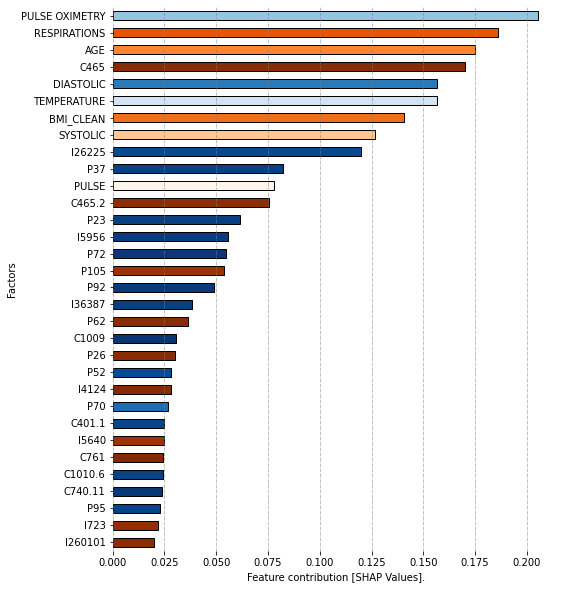

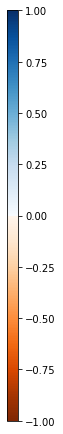

In [3]:
## Load the dataset for model training. Here it is real data. 70%
## Note: the continuous variables in the loaded files have been clipped (to remove outliers).

train_real_data = np.load('./train_raw.npy').astype(np.float)
train_real_data_index = np.linspace(0,len(train_real_data)-1,len(train_real_data)).astype('int')
random.shuffle(train_real_data_index)
train_real_data = train_real_data[train_real_data_index]
train_real_label = train_real_data[:,LABEL_INDEX].astype(np.float)
train_real_data = np.delete(train_real_data, [LABEL_INDEX]+RACE_COL, axis = 1)
print('The number of records in training (real) data is:  %d' % len(train_real_data))
print('The number of features in training (real) data is:  %d' % len(train_real_data[0]))
print('Positive vs Negative ratio in training (real) data is: %f' % (np.sum(train_real_label)/len(train_real_label)))

## load the dataset for model evaluation. Here it is real data. 30%
eval_real_data = np.load('./test_raw.npy').astype(np.float)
eval_real_data_index = np.linspace(0,len(eval_real_data)-1,len(eval_real_data)).astype('int')
# random.shuffle(eval_real_data_index)
# eval_real_data = eval_real_data[eval_real_data_index]
eval_real_label = eval_real_data[:,LABEL_INDEX].astype(np.float)
eval_real_data = np.delete(eval_real_data, [LABEL_INDEX]+RACE_COL, axis=1)
print('\nThe number of records in evaluation (real) data is: %d' % len(eval_real_data))
print('The number of features in training (real) data is: %d' % len(eval_real_data[0]))
print('Positive vs Negative ratio in evaluation (real) data is: %f' % (np.sum(eval_real_label)/len(eval_real_label)))

## model training
print('\n !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! ')

gkf = KFold(n_splits=5, shuffle=True, random_state=0).split(X=train_real_data, y=train_real_label)


#############
## try some candidates here

# param_grid = {
#     'n_estimators': [500, 1000],
#     'colsample_bytree': [0.7, 0.8],
#     'max_depth': [15, 25],
#     'num_leaves': [20, 50],
#     'reg_alpha': [1.1, 1.3],
# #     'reg_lambda': [1.1, 1.3],
#     'min_split_gain': [0.3, 0.5],
#     'subsample': [0.8, 0.9],
#     'subsample_freq': [20]
#     }
#############

param_grid = {
    'n_estimators': [500],
    'colsample_bytree': [0.7],
    'max_depth': [25],
    'num_leaves': [50],
    'reg_alpha': [1.3],
    'reg_lambda': [0.0],
    'min_split_gain': [0.5],
    'subsample': [0.9],
    'subsample_freq': [20]
    }


lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc',categorical_feature=CAT_IDX_wo_RACE_label, n_jobs = 30)

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
gbm = gsearch.fit(X=train_real_data, y=train_real_label)
print("Best parameters:\n")
print(gbm.best_params_)

y_scores = gbm.predict_proba(eval_real_data)
y_scores = y_scores[:,1]
auroc = roc_auc_score(y_score=y_scores, y_true=eval_real_label)
prauc = average_precision_score(eval_real_label, y_scores)
fpr, tpr, threshold_candidate = roc_curve(eval_real_label, y_scores)
thres_index = (tpr > RECALL_THRESHOLD).tolist().index(True)
thres = threshold_candidate[thres_index]
print("Threshold for fixing recall as %.2f is %.4f" % (RECALL_THRESHOLD, thres))
pred_y = np.array([(value>=thres)*1.0 for value in y_scores])

tn, fp, fn, tp = confusion_matrix(eval_real_label, pred_y).ravel()
ppv = tp / (tp + fp)
npv = tn / (tn + fn)
sens = tp / (tp + fn)
spes = tn / (tn + fp)
acc = (tn + tp) / (tn + fp + fn + tp)
print("      *** Test on real data AUROC: %.4f, PRAUC: %.4f, ACC: %.4f, PPV: %.4f, NPV: %.4f, Sensitivity: %.4f, Specificity: %.4f" % (
auroc, prauc, acc, ppv, npv, sens, spes))

explainer = shap.TreeExplainer(gbm.best_estimator_)
shap_df = pd.DataFrame(explainer.shap_values(eval_real_data)[1], columns = COL_LIST)
shap_df_abs = abs(shap_df)

feature_importance_mean = shap_df_abs.mean(axis=0).sort_values(ascending=False)
feature_importance_value = {}
for key, value in feature_importance_mean.items():
    if key in feature_importance_value.keys():
        feature_importance_value[key].append(value)
    else:
        feature_importance_value[key] = [value]
        
# feature_importance_std = shap_df_abs.std(axis=0).sort_values(ascending=False)
# feature_importance_var = {}
# for key, value in feature_importance_std.items():
#     if key in feature_importance_var.keys():
#         feature_importance_var[key].append(value)
#     else:
#         feature_importance_var[key] = [value]

correlation_coeff_value = {}
for key in COL_LIST:
    corr_value = np.corrcoef(shap_df[key], eval_real_data[:, COL_LIST.index(key)])[1][0]
    if key in correlation_coeff_value.keys():
        correlation_coeff_value[key].append(corr_value)
    else:
        correlation_coeff_value[key] = [corr_value]


np.save('./result/r_70_train_r_30_test_correl_coeff_value.npy', correlation_coeff_value)
shap_df.to_csv('./result/r_70_train_r_30_test_feature_importance.csv')
np.save('./result/r_70_train_r_30_test_y_estimate.npy', y_scores)
np.save('./result/r_70_train_r_30_test_y_label.npy', eval_real_label)
joblib.dump(gbm.best_estimator_, './result/r_70_train_r_30_test.pkl')

ABS_SHAP(feature_importance_value, correlation_coeff_value, 32, newcolors) 

################
## bootstrap here: 
## test data and label: eval_real_data, eval_real_label


################




# 2. train models on synthetic data 70% and evaluate models using real data 30%


In [4]:
syn_pos_size = int(np.sum(train_real_label))
syn_neg_size = int(len(train_real_label) - np.sum(train_real_label))

model_list = ['iwae', 'medgan', 'medbgan', 'emrwgan', 'medwgan', 'dpgan']

for model_name in model_list:
    
    pred_result = []
#     shap_result = []
    correlation_result = []
    
    real_auroc_result = []
    real_prauc_result = []
    real_acc_result = []
    real_ppv_result = []
    real_npv_result = []
    real_sens_result = []
    real_spes_result = []
    
    print('\n   !!!!!!!!!!!!!!!!!!! %s training is starting !!!!!!!!!!!!!!!!!!! ' % model_name)

    for run_ in range(RUN_NUM):
        
        run = run_ + 1
        print('\n ######## Syn dataset %d ######## ' % run)
        
        ## preprocess training data (synthetic) 
#         syn_dataset_tmp = np.load('./' + model_name + '_' + str(run) + '.npy')
#         syn_label_tmp = np.clip(np.round(syn_dataset_tmp[:,LABEL_INDEX]), 0.0, 1.0).tolist()
#         pos_index_list = [index for index, element in enumerate(syn_label_tmp) if element == 1.0]
#         neg_index_list = [index for index, element in enumerate(syn_label_tmp) if element == 0.0]
#         random.shuffle(pos_index_list)
#         random.shuffle(neg_index_list)
#         assert len(pos_index_list) >= syn_pos_size
#         assert len(neg_index_list) >= syn_neg_size
#         pos_index_final = pos_index_list[:syn_pos_size]
#         neg_index_final = neg_index_list[:syn_neg_size]
#         index_final = pos_index_final + neg_index_final
#         random.shuffle(index_final)
#         syn_data_mixed = syn_dataset_tmp[index_final].astype(np.float)
#         print('###### Size of Syn data is %d' % len(syn_data_mixed))
#         print('###### Num of attributes is %d' % len(syn_data_mixed[0]))
        syn_data_mixed = np.load('./round_syn_' + model_name + '_' + str(run) + '.npy')
        train_syn_label = np.clip(np.round(syn_data_mixed[:,LABEL_INDEX]), 0.0, 1.0).astype(np.float)
        train_syn_data = np.delete(syn_data_mixed, [LABEL_INDEX]+RACE_COL, axis=1)
#         for idx in CAT_IDX_wo_RACE_label:
#             train_syn_data[:, idx] = np.clip(np.round(train_syn_data[:, idx]), 0.0, 1.0)
        print(len(train_syn_data))
        print(len(train_syn_data[0]))
        
        gkf = KFold(n_splits=5, shuffle=True, random_state=0).split(X=train_syn_data, y=train_syn_label)
        
        param_grid = {
            'n_estimators': [500],
            'colsample_bytree': [0.7],
            'max_depth': [25],
            'num_leaves': [50],
            'reg_alpha': [1.3],
            'reg_lambda': [0.0],
            'min_split_gain': [0.5],
            'subsample': [0.9],
            'subsample_freq': [20]
            }

        lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc',categorical_feature=CAT_IDX_wo_RACE_label, n_jobs = 30)

        gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
        gbm = gsearch.fit(X=train_syn_data, y=train_syn_label)
        print("Best parameters:\n")
        print(gbm.best_params_)

        y_scores = gbm.predict_proba(eval_real_data)
        y_scores = y_scores[:,1]
        auroc = roc_auc_score(y_score=y_scores, y_true=eval_real_label)
        prauc = average_precision_score(eval_real_label, y_scores)
        fpr, tpr, threshold_candidate = roc_curve(eval_real_label, y_scores)
        thres_index = (tpr > RECALL_THRESHOLD).tolist().index(True)
        thres = threshold_candidate[thres_index]
        print("Threshold for fixing recall as %.2f is %.4f" % (RECALL_THRESHOLD, thres))
        pred_y = np.array([(value>=thres)*1.0 for value in y_scores])

        tn, fp, fn, tp = confusion_matrix(eval_real_label, pred_y).ravel()
        ppv = tp / (tp + fp)
        npv = tn / (tn + fn)
        sens = tp / (tp + fn)
        spes = tn / (tn + fp)
        acc = (tn + tp) / (tn + fp + fn + tp)
        print("      *** Test on real data AUROC: %.4f, PRAUC: %.4f, ACC: %.4f, PPV: %.4f, NPV: %.4f, Sensitivity: %.4f, Specificity: %.4f" % (
        auroc, prauc, acc, ppv, npv, sens, spes))
        
        real_auroc_result.append(auroc)
        real_prauc_result.append(prauc)
        real_acc_result.append(acc)
        real_ppv_result.append(ppv)
        real_npv_result.append(npv)
        real_sens_result.append(sens)
        real_spes_result.append(spes)

        explainer = shap.TreeExplainer(gbm.best_estimator_)
#         shap_value_list.extend(explainer.shap_values(eval_real_data)[1])
        shap_df = pd.DataFrame(explainer.shap_values(eval_real_data)[1], columns = COL_LIST)
        shap_df_abs = abs(shap_df)

        feature_importance_mean = shap_df_abs.mean(axis=0).sort_values(ascending=False)
        feature_importance_value = {}
        for key, value in feature_importance_mean.items():
            if key in feature_importance_value.keys():
                feature_importance_value[key].append(value)
            else:
                feature_importance_value[key] = [value]
        
        correlation_coeff_value = {}
        for key in COL_LIST:
            corr_value = np.corrcoef(shap_df[key], eval_real_data[:, COL_LIST.index(key)])[1][0]
            if key in correlation_coeff_value.keys():
                correlation_coeff_value[key].append(corr_value)
            else:
                correlation_coeff_value[key] = [corr_value]

        
        pred_result.append(y_scores)
#         shap_result.append(shap_df)
        correlation_result.append(correlation_coeff_value)
        joblib.dump(gbm.best_estimator_, './result/' + str(model_name) + '_s_train_r_30_test_' + str(run_) + '.pkl')
#         ABS_SHAP(feature_importance_value, correlation_coeff_value, 32, newcolors) 
        
        
        ################
        ## bootstrap here: 
        ## test data and label: eval_real_data, eval_real_label


        ################
        np.save('./result/' + str(model_name) + '_s_train_r_30_test_shap_' + str(run_) + '.npy', shap_df)
        
    
    print('   mean AUROC: ', np.mean(real_auroc_result), ', mean AUPRC: ', np.mean(real_prauc_result))
    
    np.save('./result/' + str(model_name) + '_s_train_r_30_test_correl_coeff.npy', correlation_result)
    np.save('./result/' + str(model_name) + '_s_train_r_30_test_y_estimate.npy', pred_result)
    
        


   !!!!!!!!!!!!!!!!!!! iwae training is starting !!!!!!!!!!!!!!!!!!! 

 ######## Syn dataset 1 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0127
      *** Test on real data AUROC: 0.5745, PRAUC: 0.0668, ACC: 0.5280, PPV: 0.0531, NPV: 0.9677, Sensitivity: 0.6038, Specificity: 0.5246


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide



 ######## Syn dataset 2 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0109
      *** Test on real data AUROC: 0.5678, PRAUC: 0.0592, ACC: 0.4816, PPV: 0.0484, NPV: 0.9646, Sensitivity: 0.6038, Specificity: 0.4762


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide



 ######## Syn dataset 3 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0279
      *** Test on real data AUROC: 0.4716, PRAUC: 0.0428, ACC: 0.3389, PPV: 0.0381, NPV: 0.9493, Sensitivity: 0.6038, Specificity: 0.3272


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide


   mean AUROC:  0.5379824561403509 , mean AUPRC:  0.05628956759929719

   !!!!!!!!!!!!!!!!!!! medgan training is starting !!!!!!!!!!!!!!!!!!! 

 ######## Syn dataset 1 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0172
      *** Test on real data AUROC: 0.6715, PRAUC: 0.1112, ACC: 0.5894, PPV: 0.0609, NPV: 0.9712, Sensitivity: 0.6038, Specificity: 0.5888


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide



 ######## Syn dataset 2 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0046
      *** Test on real data AUROC: 0.6878, PRAUC: 0.1212, ACC: 0.6917, PPV: 0.0805, NPV: 0.9755, Sensitivity: 0.6038, Specificity: 0.6956


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide



 ######## Syn dataset 3 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0267
      *** Test on real data AUROC: 0.5636, PRAUC: 0.0608, ACC: 0.4875, PPV: 0.0490, NPV: 0.9650, Sensitivity: 0.6038, Specificity: 0.4823


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide


   mean AUROC:  0.6409627356231771 , mean AUPRC:  0.09772949847392669

   !!!!!!!!!!!!!!!!!!! medbgan training is starting !!!!!!!!!!!!!!!!!!! 

 ######## Syn dataset 1 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0210
      *** Test on real data AUROC: 0.5676, PRAUC: 0.0608, ACC: 0.4836, PPV: 0.0486, NPV: 0.9647, Sensitivity: 0.6038, Specificity: 0.4783


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide



 ######## Syn dataset 2 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0082
      *** Test on real data AUROC: 0.5594, PRAUC: 0.0570, ACC: 0.4493, PPV: 0.0456, NPV: 0.9620, Sensitivity: 0.6038, Specificity: 0.4424


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide



 ######## Syn dataset 3 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0117
      *** Test on real data AUROC: 0.6633, PRAUC: 0.1213, ACC: 0.6093, PPV: 0.0639, NPV: 0.9721, Sensitivity: 0.6038, Specificity: 0.6095


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide


   mean AUROC:  0.5967905184798225 , mean AUPRC:  0.07967369311673123

   !!!!!!!!!!!!!!!!!!! emrwgan training is starting !!!!!!!!!!!!!!!!!!! 

 ######## Syn dataset 1 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0146
      *** Test on real data AUROC: 0.7177, PRAUC: 0.1439, ACC: 0.7015, PPV: 0.0831, NPV: 0.9758, Sensitivity: 0.6038, Specificity: 0.7058


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide



 ######## Syn dataset 2 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0191
      *** Test on real data AUROC: 0.7386, PRAUC: 0.1841, ACC: 0.7766, PPV: 0.1099, NPV: 0.9782, Sensitivity: 0.6038, Specificity: 0.7842


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide



 ######## Syn dataset 3 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0180
      *** Test on real data AUROC: 0.6985, PRAUC: 0.1232, ACC: 0.7078, PPV: 0.0848, NPV: 0.9760, Sensitivity: 0.6038, Specificity: 0.7124


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide


   mean AUROC:  0.7182625919637804 , mean AUPRC:  0.1503824290263371

   !!!!!!!!!!!!!!!!!!! medwgan training is starting !!!!!!!!!!!!!!!!!!! 

 ######## Syn dataset 1 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0144
      *** Test on real data AUROC: 0.6392, PRAUC: 0.0957, ACC: 0.6034, PPV: 0.0633, NPV: 0.9721, Sensitivity: 0.6077, Specificity: 0.6032


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide



 ######## Syn dataset 2 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0185
      *** Test on real data AUROC: 0.6548, PRAUC: 0.0824, ACC: 0.6234, PPV: 0.0662, NPV: 0.9728, Sensitivity: 0.6038, Specificity: 0.6243


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide



 ######## Syn dataset 3 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0191
      *** Test on real data AUROC: 0.7359, PRAUC: 0.1547, ACC: 0.7680, PPV: 0.1060, NPV: 0.9779, Sensitivity: 0.6038, Specificity: 0.7752


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide


   mean AUROC:  0.6766122502285491 , mean AUPRC:  0.11093243566583823

   !!!!!!!!!!!!!!!!!!! dpgan training is starting !!!!!!!!!!!!!!!!!!! 

 ######## Syn dataset 1 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0121
      *** Test on real data AUROC: 0.6403, PRAUC: 0.0918, ACC: 0.5517, PPV: 0.0559, NPV: 0.9692, Sensitivity: 0.6038, Specificity: 0.5494


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide



 ######## Syn dataset 2 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0111
      *** Test on real data AUROC: 0.6882, PRAUC: 0.1130, ACC: 0.6528, PPV: 0.0717, NPV: 0.9740, Sensitivity: 0.6038, Specificity: 0.6550


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide



 ######## Syn dataset 3 ######## 
14349
2590


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0046
      *** Test on real data AUROC: 0.6671, PRAUC: 0.0927, ACC: 0.6233, PPV: 0.0662, NPV: 0.9727, Sensitivity: 0.6038, Specificity: 0.6241


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide


   mean AUROC:  0.6652111357798963 , mean AUPRC:  0.09914840717809431


# 3. train models on real data 30% and evaluate models using real data 70%

The number of records in training (real) data is:  6150
The number of features in training (real) data is:  2590
Positive vs Negative ratio in training (real) data is: 0.042276

The number of records in evaluation (real) data is: 14349
The number of features in training (real) data is: 2590
Positive vs Negative ratio in evaluation (real) data is: 0.037703

 !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! 
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}
Threshold for fixing recall as 0.60 is 0.0374
      *** Test on real data AUROC: 0.7807, PRAUC: 0.1760, ACC: 0.8045, PPV: 0.1115, NPV: 0.9811, Sensitivity: 0.6007, Specificity: 0.8125


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
invalid value encountered in true_divide
invalid value encountered in true_divide


['I4850', 'C470', 'C478', 'C375.1', 'I6711', 'I7258', 'P36', 'P96', 'C512.8', 'I6387', 'I221147', 'C483', 'C512', 'P57', 'P94', 'GENDER_SOURCE_VALUE', 'C476', 'I5956', 'RESPIRATIONS', 'P92', 'I8591', 'C401.1', 'PULSE OXIMETRY', 'PULSE', 'BMI_CLEAN', 'P105', 'DIASTOLIC', 'SYSTOLIC', 'I723', 'AGE', 'C465', 'TEMPERATURE']


,Variable,SHAP_abs,SHAP_std,Corr,Sign
31,I4850,0.023000,0.0,-0.990555,"[0.5076733055426895, 0.15664659564613248, 0.01..."
30,C470,0.023308,0.0,0.966083,"[0.03137254901960784, 0.2208429828624363, 0.46..."
29,C478,0.025921,0.0,-0.994648,"[0.4980392156862745, 0.15294117647058825, 0.01..."
28,C375.1,0.026075,0.0,-0.987582,"[0.5076733055426895, 0.15664659564613248, 0.01..."
27,I6711,0.027083,0.0,0.971007,"[0.03137254901960784, 0.212691060676239, 0.455..."
26,I7258,0.027648,0.0,-0.982421,"[0.5173073953991045, 0.1603520148216767, 0.015..."
25,P36,0.028081,0.0,0.918276,"[0.03137254901960784, 0.2697545159796202, 0.54..."
24,P96,0.033298,0.0,0.894346,"[0.03137254901960784, 0.29421028253821213, 0.5..."
23,C512.8,0.034369,0.0,-0.981883,"[0.5173073953991045, 0.1603520148216767, 0.015..."
22,I6387,0.036567,0.0,0.897773,"[0.03137254901960784, 0.29421028253821213, 0.5..."


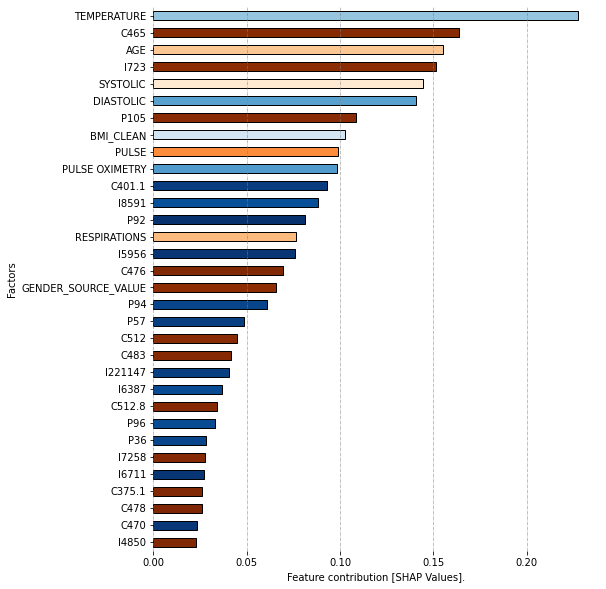

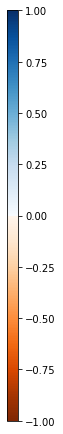

In [5]:
train_real_data = np.load('./test_raw.npy').astype(np.float)
train_real_data_index = np.linspace(0,len(train_real_data)-1,len(train_real_data)).astype('int')
random.shuffle(train_real_data_index)
train_real_data = train_real_data[train_real_data_index]
train_real_label = train_real_data[:,LABEL_INDEX].astype(np.float)
train_real_data = np.delete(train_real_data, [LABEL_INDEX]+RACE_COL, axis = 1)
print('The number of records in training (real) data is:  %d' % len(train_real_data))
print('The number of features in training (real) data is:  %d' % len(train_real_data[0]))
print('Positive vs Negative ratio in training (real) data is: %f' % (np.sum(train_real_label)/len(train_real_label)))

## load the dataset for model evaluation. Here it is real data. 30%
eval_real_data = np.load('./train_raw.npy').astype(np.float)
eval_real_data_index = np.linspace(0,len(eval_real_data)-1,len(eval_real_data)).astype('int')
# random.shuffle(eval_real_data_index)
# eval_real_data = eval_real_data[eval_real_data_index]
eval_real_label = eval_real_data[:,LABEL_INDEX].astype(np.float)
eval_real_data = np.delete(eval_real_data, [LABEL_INDEX]+RACE_COL, axis=1)
print('\nThe number of records in evaluation (real) data is: %d' % len(eval_real_data))
print('The number of features in training (real) data is: %d' % len(eval_real_data[0]))
print('Positive vs Negative ratio in evaluation (real) data is: %f' % (np.sum(eval_real_label)/len(eval_real_label)))

## model training
print('\n !!!!!!!!!!!!!!!!!!! training is starting !!!!!!!!!!!!!!!!!!! ')
## metrics for bootstrap
real_auroc_result = []
real_prauc_result = []
real_acc_result = []
real_ppv_result = []
real_npv_result = []
real_sens_result = []
real_spes_result = []

gkf = KFold(n_splits=5, shuffle=True, random_state=0).split(X=train_real_data, y=train_real_label)


#############
## try some candidates here

# param_grid = {
#     'n_estimators': [500, 1000],
#     'colsample_bytree': [0.7, 0.8],
#     'max_depth': [15, 25],
#     'num_leaves': [20, 50],
#     'reg_alpha': [1.1, 1.3],
# #     'reg_lambda': [1.1, 1.3],
#     'min_split_gain': [0.3, 0.5],
#     'subsample': [0.8, 0.9],
#     'subsample_freq': [20]
#     }
#############

param_grid = {
    'n_estimators': [500],
    'colsample_bytree': [0.7],
    'max_depth': [25],
    'num_leaves': [50],
    'reg_alpha': [1.3],
    'reg_lambda': [0.0],
    'min_split_gain': [0.5],
    'subsample': [0.9],
    'subsample_freq': [20]
    }


lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc',categorical_feature=CAT_IDX_wo_RACE_label, n_jobs = 30)

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
gbm = gsearch.fit(X=train_real_data, y=train_real_label)
print("Best parameters:\n")
print(gbm.best_params_)

y_scores = gbm.predict_proba(eval_real_data)
y_scores = y_scores[:,1]
auroc = roc_auc_score(y_score=y_scores, y_true=eval_real_label)
prauc = average_precision_score(eval_real_label, y_scores)
fpr, tpr, threshold_candidate = roc_curve(eval_real_label, y_scores)
thres_index = (tpr > RECALL_THRESHOLD).tolist().index(True)
thres = threshold_candidate[thres_index]
print("Threshold for fixing recall as %.2f is %.4f" % (RECALL_THRESHOLD, thres))
pred_y = np.array([(value>=thres)*1.0 for value in y_scores])

tn, fp, fn, tp = confusion_matrix(eval_real_label, pred_y).ravel()
ppv = tp / (tp + fp)
npv = tn / (tn + fn)
sens = tp / (tp + fn)
spes = tn / (tn + fp)
acc = (tn + tp) / (tn + fp + fn + tp)
print("      *** Test on real data AUROC: %.4f, PRAUC: %.4f, ACC: %.4f, PPV: %.4f, NPV: %.4f, Sensitivity: %.4f, Specificity: %.4f" % (
auroc, prauc, acc, ppv, npv, sens, spes))

explainer = shap.TreeExplainer(gbm.best_estimator_)
shap_df = pd.DataFrame(explainer.shap_values(eval_real_data)[1], columns = COL_LIST)
shap_df_abs = abs(shap_df)

feature_importance_mean = shap_df_abs.mean(axis=0).sort_values(ascending=False)
feature_importance_value = {}
for key, value in feature_importance_mean.items():
    if key in feature_importance_value.keys():
        feature_importance_value[key].append(value)
    else:
        feature_importance_value[key] = [value]
        
# feature_importance_std = shap_df_abs.std(axis=0).sort_values(ascending=False)
# feature_importance_var = {}
# for key, value in feature_importance_std.items():
#     if key in feature_importance_var.keys():
#         feature_importance_var[key].append(value)
#     else:
#         feature_importance_var[key] = [value]

correlation_coeff_value = {}
for key in COL_LIST:
    corr_value = np.corrcoef(shap_df[key], eval_real_data[:, COL_LIST.index(key)])[1][0]
    if key in correlation_coeff_value.keys():
        correlation_coeff_value[key].append(corr_value)
    else:
        correlation_coeff_value[key] = [corr_value]


np.save('./result/r_30_train_r_70_test_correl_coeff_value.npy', correlation_coeff_value)
shap_df.to_csv('./result/r_30_train_r_70_test_feature_importance.csv')
np.save('./result/r_30_train_r_70_test_y_estimate.npy', y_scores)
np.save('./result/r_30_train_r_70_test_y_label.npy', eval_real_label)
joblib.dump(gbm.best_estimator_, './result/r_30_train_r_70.pkl')

ABS_SHAP(feature_importance_value, correlation_coeff_value, 32, newcolors) 

################
## bootstrap here: 
## test data and label: eval_real_data, eval_real_label


################

# 4. train models on real data 30% and evaluate models using syn data 70%

In [6]:
#### model training

train_real_data = np.load('./test_raw.npy').astype(np.float)
train_real_data_index = np.linspace(0,len(train_real_data)-1,len(train_real_data)).astype('int')
random.shuffle(train_real_data_index)
train_real_data = train_real_data[train_real_data_index]
train_real_label = train_real_data[:,LABEL_INDEX].astype(np.float)
train_real_data = np.delete(train_real_data, [LABEL_INDEX]+RACE_COL, axis = 1)
print('The number of records in training (real) data is:  %d' % len(train_real_data))
print('The number of features in training (real) data is:  %d' % len(train_real_data[0]))
print('Positive vs Negative ratio in training (real) data is: %f' % (np.sum(train_real_label)/len(train_real_label)))


gkf = KFold(n_splits=5, shuffle=True, random_state=0).split(X=train_real_data, y=train_real_label)

#############
## try some candidates here

# param_grid = {
#     'n_estimators': [500, 1000],
#     'colsample_bytree': [0.7, 0.8],
#     'max_depth': [15, 25],
#     'num_leaves': [20, 50],
#     'reg_alpha': [1.1, 1.3],
# #     'reg_lambda': [1.1, 1.3],
#     'min_split_gain': [0.3, 0.5],
#     'subsample': [0.8, 0.9],
#     'subsample_freq': [20]
#     }
#############

param_grid = {
    'n_estimators': [500],
    'colsample_bytree': [0.7],
    'max_depth': [25],
    'num_leaves': [50],
    'reg_alpha': [1.3],
    'reg_lambda': [0.0],
    'min_split_gain': [0.5],
    'subsample': [0.9],
    'subsample_freq': [20]
    }

lgb_estimator = lgb.LGBMClassifier(boosting_type='gbdt',  objective='binary', num_boost_round=2000, learning_rate=0.01, metric='auc',categorical_feature=CAT_IDX_wo_RACE_label, n_jobs = 30)

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
gbm = gsearch.fit(X=train_real_data, y=train_real_label)
print("Best parameters:\n")
print(gbm.best_params_)


#### model evaluation

model_list = ['iwae', 'medgan', 'medbgan', 'emrwgan', 'medwgan', 'dpgan']

# model_list = ['emrwgan']

for model_name in model_list:
    
    pred_result = []
    label_gt = []
    
    print('\n   !!!!!!!!!!!!!!!!!!! %s evaluation is starting !!!!!!!!!!!!!!!!!!! ' % model_name)
    
    syn_auroc_result = []
    syn_prauc_result = []
    syn_acc_result = []
    syn_ppv_result = []
    syn_npv_result = []
    syn_sens_result = []
    syn_spes_result = []

    for run_ in range(RUN_NUM):
        
        run = run_ + 1
        print('\n ######## Syn dataset %d ######## ' % run)
        
        syn_data = np.load('./round_syn_' + model_name + '_' + str(run) + '.npy') ## note: this syn version is not the raw data, but the curated version in block 2. (use the same file names here)
        syn_label = np.clip(np.round(syn_data[:,LABEL_INDEX]), 0.0, 1.0).astype(np.float)
        syn_data = np.delete(syn_data, [LABEL_INDEX]+RACE_COL, axis=1)
#         for idx in CAT_IDX_wo_RACE_label:
#             syn_data[:, idx] = np.clip(np.round(syn_data[:, idx]), 0.0, 1.0)    
        print('###### Size of Syn data is %d' % len(syn_data))
        print('###### Num of attributes is %d' % len(syn_data[0]))
        
        y_scores = gbm.best_estimator_.predict_proba(syn_data)
        y_scores = y_scores[:,1]
        auroc = roc_auc_score(y_score=y_scores, y_true=syn_label)
        prauc = average_precision_score(syn_label, y_scores)
        fpr, tpr, threshold_candidate = roc_curve(syn_label, y_scores)
        thres_index = (tpr > RECALL_THRESHOLD).tolist().index(True)
        thres = threshold_candidate[thres_index]
        print("Threshold for fixing recall as %.2f is %.4f" % (RECALL_THRESHOLD, thres))
        pred_y = np.array([(value>=thres)*1.0 for value in y_scores])

        tn, fp, fn, tp = confusion_matrix(syn_label, pred_y).ravel()
        ppv = tp / (tp + fp)
        npv = tn / (tn + fn)
        sens = tp / (tp + fn)
        spes = tn / (tn + fp)
        acc = (tn + tp) / (tn + fp + fn + tp)
        print("      *** Test on syn data AUROC: %.4f, PRAUC: %.4f, ACC: %.4f, PPV: %.4f, NPV: %.4f, Sensitivity: %.4f, Specificity: %.4f" % (
        auroc, prauc, acc, ppv, npv, sens, spes))   
        
        syn_auroc_result.append(auroc)
        syn_prauc_result.append(prauc)
        syn_acc_result.append(acc)
        syn_ppv_result.append(ppv)
        syn_npv_result.append(npv)
        syn_sens_result.append(sens)
        syn_spes_result.append(spes)
        
        pred_result.append(y_scores.tolist())
        label_gt.append(syn_label.tolist())
               
        ################
        ## bootstrap here: 
        ## test data and label: eval_real_data, eval_real_label


        ################
    
    print('   mean AUROC: ', np.mean(syn_auroc_result), ', mean AUPRC: ', np.mean(syn_prauc_result))
    np.save('./result/' + str(model_name) + '_r_30_train_s_test_label_gt.npy', label_gt)
    np.save('./result/' + str(model_name) + '_r_30_train_s_test_y_estimate.npy', pred_result)
    
        

The number of records in training (real) data is:  6150
The number of features in training (real) data is:  2590
Positive vs Negative ratio in training (real) data is: 0.042276


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


Found `num_boost_round` in params. Will use it instead of argument
categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
Best parameters:

{'colsample_bytree': 0.7, 'max_depth': 25, 'min_split_gain': 0.5, 'n_estimators': 500, 'num_leaves': 50, 'reg_alpha': 1.3, 'reg_lambda': 0.0, 'subsample': 0.9, 'subsample_freq': 20}

   !!!!!!!!!!!!!!!!!!! iwae evaluation is starting !!!!!!!!!!!!!!!!!!! 

 ######## Syn dataset 1 ######## 
###### Size of Syn data is 14349
###### Num of attributes is 2590
Threshold for fixing recall as 0.60 is 0.0143
      *** Test on syn data AUROC: 0.5108, PRAUC: 0.0391, ACC: 0.4287, PPV: 0.0391, NPV: 0.9643, Sensitivity: 0.6007, Specificity: 0.4219

 ######## Syn dataset 2 ######## 
###### Size of Syn data is 14349
###### Num of attributes is 2590
Threshold for fixing recall as 0.60 is 0.0147
      *** Test on syn data AUROC: 0.5011, PRAUC: 0.0377, ACC: 0.4301, PPV: 0.0392, NPV: 0.9644, Sensitivity: 0.6007, Specificity: 0.4234

 ######## Syn dataset 3 ######## 
##